In [31]:
# 导入必要的头文件
from keras.layers import Dense, Input, Activation, Embedding, Lambda
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from keras.datasets import imdb
# 下载imdb数据
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000)
# 构建单词映射表
word2index = imdb.get_word_index()
word2index["UNK"] = 0 
index2word = {value : key for key, value in word2index.items()}

In [13]:
max_length = float("-inf")
for item in x_train:
    if len(item) > max_length:
        max_length = len(item)
        
for item in x_test:
    if len(item) > max_length:
        max_length = len(item)
        
print(max_length)

2494


In [15]:
x_train = pad_sequences(x_train, padding = "post", maxlen = max_length, value = 0, dtype = "int32")
x_test = pad_sequences(x_test, padding = "post", maxlen = max_length, value = 0, dtype = "int32")

<class 'numpy.ndarray'>


In [21]:
# 构建模型
voca_size = len(word2index)
embed_size = 300

input_imdb = Input(shape = (max_length,))
embedding_1 = Embedding(input_dim = voca_size, output_dim = embed_size, input_length = max_length, embeddings_initializer = "glorot_uniform")(input_imdb)
lambda_1 = Lambda(lambda x : K.mean(x, axis = 1), output_shape = (embed_size,))(embedding_1)
dense_1 = Dense(units = 256, activation = "relu", name = "dense_1")(lambda_1)
dense_2 = Dense(units = 128, activation = "relu", name = "dense_2")(dense_1)
dense_3 = Dense(units = 1, activation = "sigmoid", name = "dense_3")(dense_2)
model = Model(inputs = input_imdb, outputs = dense_3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2494)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 2494, 300)         26575200  
_________________________________________________________________
lambda_2 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 26,685,281
Trainable params: 26,685,281
Non-trainable params: 0
________________________________________________________________

In [26]:
# 编译模型
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# 运行模型
early_stopping = EarlyStopping(monitor = "val_acc", patience = 5)
history = model.fit(x_train, y_train, batch_size = 32, epochs = 20, verbose = 1, validation_split = 0.2, callbacks = [early_stopping])

# 测试模型
score = model.evaluate(x_test, y_test, verbose = 1)
print("test score:", score[0], "test accuracy:", score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1164 - acc: 0.9560 - val_loss: 0.5467 - val_acc: 0.8280
Epoch 2/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0988 - acc: 0.9653 - val_loss: 0.5654 - val_acc: 0.8772
Epoch 3/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0872 - acc: 0.9692 - val_loss: 0.5105 - val_acc: 0.8748
Epoch 4/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0889 - acc: 0.9684 - val_loss: 0.5078 - val_acc: 0.8522
Epoch 5/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0694 - acc: 0.9759 - val_loss: 0.5683 - val_acc: 0.8858
Epoch 6/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0659 - acc: 0.9759 - val_loss: 0.6268 - val_acc: 0.8818
Epoch 7/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0635 - acc: 0.9770 - val_loss: 0.6667 - val_acc:

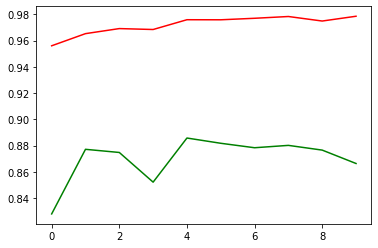

In [29]:
# 绘制结果
plt.figure()
times = [i for i in range(len(history.history["acc"]))]
plt.plot(times, history.history["acc"], c = "r", label = "train acc")
plt.plot(times, history.history["val_acc"], c = "g", label = "validation acc")
plt.show()